# gappa tutorial
In this tutorial you will learn step-by-step to use gappa in order to
 * calculate an SED from a particle distribution
 * perform a particle evolution in the presence of energy losses
 * calculate some galactic gas densities
 * tinker with the galactic spiral arm structure
 * dice some random galactic pulsar positions

1. Get the SED from a particle distribution
-------------------------------------------
create a 2D numpy array representing an electron and a 
proton SED.  
The shape is your choice, but the normalisation
should be 10^50erg  
in protons and 10^47erg in electrons!

In [2]:
%matplotlib inline
import gappa as gp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Get an energy axis:

In [3]:
# note: all input energies are in erg!
emin = 1e-3 * gp.TeV_to_erg
emax = 1e4 * gp.TeV_to_erg
e = np.logspace(np.log10(emin),np.log10(emax),100)

Make your spectral assumption:

In [4]:
# my choice is a power-law for the electrons
# and protons with spectral index 'spind' and 
# exp.cut-off at 'ecute'(electrons) and 'ecutp'(protons)
# plus a oscillation for the protons
spind = 2.1
ecute = 1e2 * gp.TeV_to_erg
ecutp = 1e3 * gp.TeV_to_erg

# energy in particles
we = 1e47
wp = 1e50

nel = e**(-spind) * np.exp(-e/ecute)
npr = e**(-spind) * np.exp(-e/ecutp) * (1 + np.sin(5*np.log10(e)))

Roughly normalise with numpy:

In [5]:
nel *= we/np.sum((e * nel)[1:]* np.diff(e))
npr *= wp/np.sum((e * npr)[1:]* np.diff(e))

And the result looks like this:

(1e+38, 1e+54)

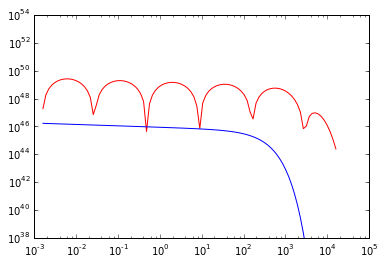

In [6]:
plt.loglog(e,e*e*npr,c="red")
plt.loglog(e,e*e*nel,c="blue")
plt.ylim(1.e38,1.e54)

Initialise a gappa Radiation object and set these spectra:

In [7]:
rad = gp.Radiation()
# gappa takes 2D arrays as input
rad.SetElectrons(zip(e,nel))
rad.SetProtons(zip(e,npr))

Now set some parameters:

In [8]:
# BField in Gauss
rad.SetBField(1e-5)
# Distance in pc
rad.SetDistance(1e3)
# Ambient density in cm^-3
rad.SetAmbientDensity(1.)

In order to set radiation fields, you can either
 * add a greybody
 * set a custom spectrum

(10000000000000.0, 1e+19)

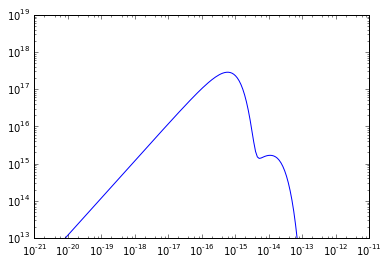

In [9]:
# again, energies are always in erg!
rad.AddThermalTargetPhotons(2.7,0.25*gp.eV_to_erg) #CMB
rad.AddThermalTargetPhotons(50.,0.5*gp.eV_to_erg) #some FIR field
targ = np.array(rad.GetTargetPhotons())
plt.loglog(targ[:,0],targ[:,1])
plt.ylim(1e13,1e19)

Add a crazy radiation field:

In [10]:
et = np.logspace(-20,-13,100)
nt = 1.e16*(1.+10.*np.sin(10.*np.log10(et))/np.log10(et))
rad.AddArbitraryTargetPhotons(zip(et,nt))
targ = np.array(rad.GetTargetPhotons())

(10000000000000.0, 1e+19)

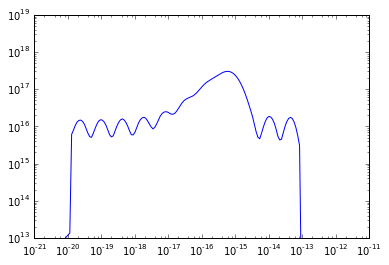

In [11]:
plt.loglog(targ[:,0],targ[:,1])
plt.ylim(1e13,1e19)

Finally, calculate and retrieve the SEDs:

In [12]:
rad.CalculateDifferentialPhotonSpectrum()

to = np.array(rad.GetTotalSED())
pp = np.array(rad.GetPPSED())
ic = np.array(rad.GetICSED())
br = np.array(rad.GetBremsstrahlungSED())
sy = np.array(rad.GetSynchrotronSED())

(1e-14, 1e-09)

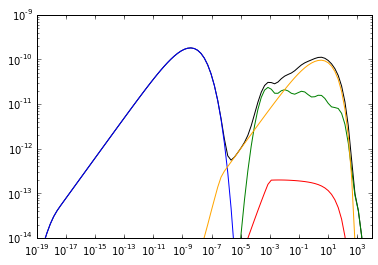

In [13]:
plt.loglog(to[:,0],to[:,1],c="black")
plt.loglog(pp[:,0],pp[:,1],c="green")
plt.loglog(sy[:,0],sy[:,1],c="blue")
plt.loglog(br[:,0],br[:,1],c="red")
plt.loglog(ic[:,0],ic[:,1],c="orange")
plt.ylim(1e-14,1e-9)

Thumbs Up!

2. Do a particle evolution
--------------------------
Steps:
 * Set source age
 * set luminosity evolution
 * set B-field evolution
 * set ambient density
 * set lookup for IC losses
 
Set age and make a time axis:

In [14]:
# note: all times are in years
age = 1e3
tmin = 1e1
tmax = age * 1e6 # this has to be high!
t = np.logspace(np.log10(tmin),np.log10(tmax),200)

Now define luminosity and B-field evolution.  
NOTE: If you have time-dependent losses, the speed of the  
calculation is determined by the strength of the losses.  
The higher the losses (e.g. very high B-field), the slower.

In [15]:
bt = 1e-3 / np.sqrt(t)
lumt = 1e38/(1. + t/500.)**2

(0.0, 1000.0)

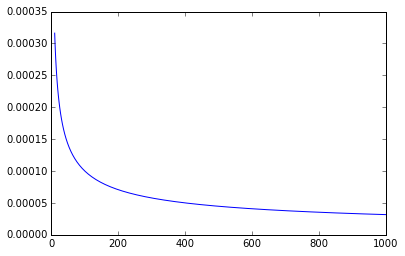

In [16]:
plt.plot(t,bt)
plt.xlim(0.,1000.)

(0.0, 1000.0)

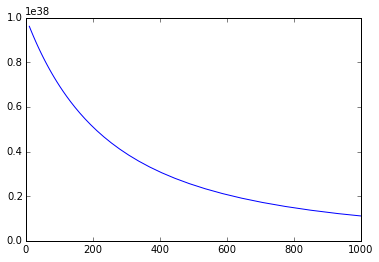

In [17]:
plt.plot(t,lumt)
plt.xlim(0.,1000.)

Create a 'Particle' object and set these evolutions

In [18]:
par = gp.Particles()
par.SetAge(age)
par.SetBFieldLookup(zip(t,bt))
par.SetLuminosityLookup(zip(t,lumt))
par.SetAmbientDensity(2.)

For IC losses, a lookup has to be created.  
This is done with the 'Radiation' object.  
Let's just use the previously defined radiation field.

In [19]:
rad.CreateICLossLookup()
icl = np.array(rad.GetICLossLookup())

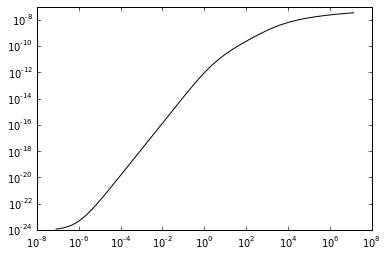

In [20]:
plt.loglog(icl[:,0],icl[:,1],c="black")

In [21]:
par.SetICLossLookup(icl)

The only thing missing is the shape of the injection spectrum.  
Let's assume our source is injecting a broken power law:

In [22]:
par.SetLowSpectralIndex(1.5)
par.SetSpectralIndex(2.5)
par.SetBreakEnergy(0.1*gp.TeV_to_erg)
par.SetEmax(5e2)

Now we can do the evolution calculation!

In [23]:
par.CalculateParticleSpectrum("electrons")
el = np.array(par.GetParticleSED())

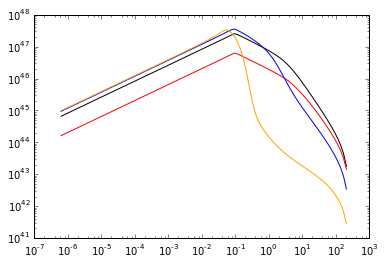

In [24]:
plt.loglog(el[:,0],el[:,1],c="black")
plt.ylim(1e41,1e48)

par.SetAge(.1*age)
par.CalculateParticleSpectrum("electrons")
el2 = np.array(par.GetParticleSED())
plt.loglog(el2[:,0],el2[:,1],c="red")

par.SetAge(10.*age)
par.CalculateParticleSpectrum("electrons")
el3 = np.array(par.GetParticleSED())
plt.loglog(el3[:,0],el3[:,1],c="blue")

par.SetAge(100.*age)
par.CalculateParticleSpectrum("electrons")
el4 = np.array(par.GetParticleSED())
plt.loglog(el4[:,0],el4[:,1],c="orange")

Now let's calculate the radiation spectrum.  
Here, we set the parameters of the radiation object that  
corresponds to the what's in the 'Particle' object at t=age

In [25]:
rad.SetBField(par.GetBField())
rad.SetAmbientDensity(par.GetAmbientDensity())
rad.SetElectrons(par.GetParticleSpectrum())
print par.GetBField()
rad.CalculateDifferentialPhotonSpectrum()
to = np.array(rad.GetTotalSED())
pp = np.array(rad.GetPPSED())
ic = np.array(rad.GetICSED())
br = np.array(rad.GetBremsstrahlungSED())
sy = np.array(rad.GetSynchrotronSED())

3.16230481376e-06


And plot it:

(1e-16, 1e-09)

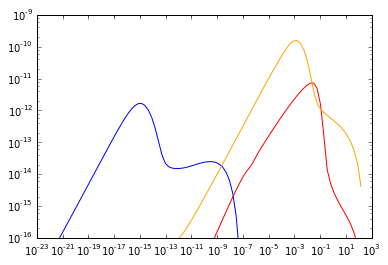

In [26]:
#plt.loglog(to[:,0],to[:,1],c="black")
plt.loglog(sy[:,0],sy[:,1],c="blue")
plt.loglog(br[:,0],br[:,1],c="red")
plt.loglog(ic[:,0],ic[:,1],c="orange")
plt.ylim(1e-16,1e-9)


3. Dice some galactic distributions
-----------------------------------
Now let's try to dice some galactic distributions!

First lets dice some x-y coordinates in the galactic disk:

In [162]:
bb = 20000
xx = 20*np.random.random(bb)-10
yy = 20*np.random.random(bb)-5

Initialise an 'Astro' object:

In [163]:
ao = gp.Astro()

Function that gets hydrogen densities at (x,y,0) coordinates,  
either from the original model by Ferriere 2001 and modulated  
with spiral arms:

In [164]:
def get_densities(xx,yy):
    nn = []
    nnmod = []
    for i in xrange(len(xx)):
        n = ao.HIDensity(xx[i],yy[i],0.)+ao.H2Density(xx[i],yy[i],0.)
        nn.append(n)
        nm = ao.ModulateGasDensityWithSpirals(n,xx[i],yy[i],0.)
        nnmod.append(nm)
    return nn,nnmod

In [165]:
nn,nnmod = get_densities(xx,yy)

Plot the unmodulated and modulated densities:

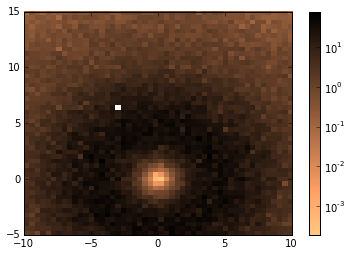

In [166]:
plt.hist2d(xx,yy,weights=nn,normed=False,bins=(50,50),cmap=plt.cm.copper_r,alpha=1.,norm=LogNorm())
cb = plt.colorbar()

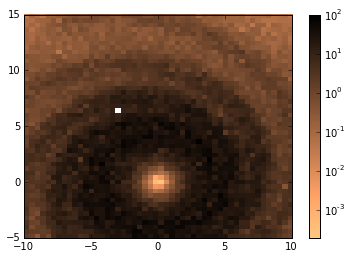

In [167]:
plt.hist2d(xx,yy,weights=nnmod,normed=False,bins=(50,50),cmap=plt.cm.copper_r,alpha=1.,norm=LogNorm())
cb = plt.colorbar()

Disable an arm, change the arm model, change the arms width:

In [168]:
ao.DisableArm(1)
dummy,nnmodnoarm = get_densities(xx,yy)
ao.EnableArm(4)

ao.SetSpiralArmModel("TaylorCordes")
dummy,nnmodtc = get_densities(xx,yy)

ao.SetArmWidth(0.2)
dummy,nnmodthin = get_densities(xx,yy)


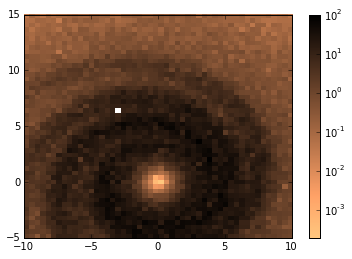

In [169]:
plt.hist2d(xx,yy,weights=nnmodnoarm,normed=False,bins=(50,50),cmap=plt.cm.copper_r,alpha=1.,norm=LogNorm())
cb = plt.colorbar()

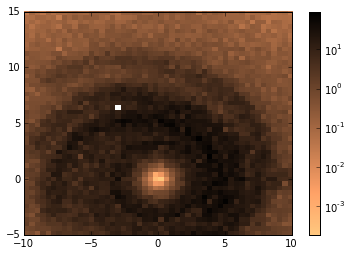

In [170]:
plt.hist2d(xx,yy,weights=nnmodtc,normed=False,bins=(50,50),cmap=plt.cm.copper_r,alpha=1.,norm=LogNorm())
cb = plt.colorbar()

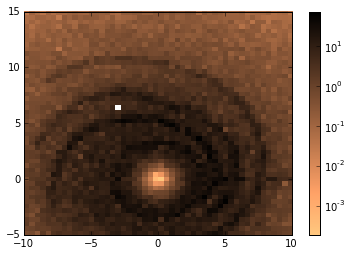

In [171]:
plt.hist2d(xx,yy,weights=nnmodthin,normed=False,bins=(50,50),cmap=plt.cm.copper_r,alpha=1.,norm=LogNorm())
cb = plt.colorbar()

Now get some random positions in the galaxy that follows  
the Case&Bhattacharya surface density model:

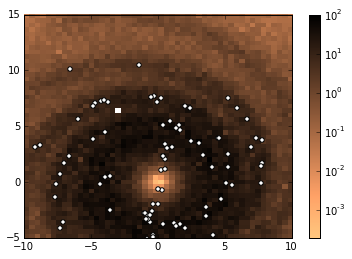

In [177]:
ao.SetSpiralArmModel("Vallee")
pos = np.array(ao.DiceGalacticPositions(100))
plt.hist2d(xx,yy,weights=nnmod,normed=False,bins=(50,50),cmap=plt.cm.copper_r,alpha=1.,norm=LogNorm())
cb = plt.colorbar()
plt.scatter(pos[:,0],pos[:,1],c="white")